In [16]:
## Standard libraries
import os
import json
import math
import numpy as np
import time
import pandas as pd
import re
import string
from google.colab import drive

#sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

## Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# PyTorch Lightning
try:
    
    import pytorch_lightning as pl
    import torchmetrics
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
    import torchmetrics

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import AUROC, Precision, Recall, F1Score, Accuracy

# try:
#   from datasets import load_dataset
# except ModuleNotFoundError:
#   !pip install --quiet datasets
#   from datasets import load_dataset


In [17]:
drive.mount('/drive')
%cd '/drive/MyDrive/ml-latest-small'

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/MyDrive/ml-latest-small


## Implementación de NCF (HE et al.) y utilizando como guía https://towardsdatascience.com/deep-learning-based-recommender-systems-3d120201db7e 🚀

## Procesamiento de los datos 🤔

### Extraer todos los generos del dataset movies y visualizar distribucion

In [18]:
df_movies = pd.read_csv('movies.csv')

In [19]:
df_movies['genres'] = df_movies['genres'].str.split('|')

In [20]:
#one hot embedding
mlb = MultiLabelBinarizer(sparse_output=True)

df_movies = df_movies.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_movies.pop('genres')),
                index=df_movies.index,
                columns=mlb.classes_))

df_movies = df_movies.drop(columns=['(no genres listed)'])

In [21]:
df_movies

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_labels = df_movies.columns.to_list()[2:]
print(df_labels)

['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [23]:
data_count = df_movies[df_labels].sum()

In [24]:
data_count

Action         1828
Adventure      1263
Animation       611
Children        664
Comedy         3756
Crime          1199
Documentary     440
Drama          4361
Fantasy         779
Film-Noir        87
Horror          978
IMAX            158
Musical         334
Mystery         573
Romance        1596
Sci-Fi          980
Thriller       1894
War             382
Western         167
dtype: int64

In [25]:
labels = pd.DataFrame(df_labels, columns=['Genres'])
labels.to_csv('labels.csv')

### Extraer datos del dataset ratings y visualizar distribucion

In [26]:
df_ratings = pd.read_csv('ratings.csv')

In [27]:
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [28]:
#mean rating by movieId
df_mean = df_ratings.groupby('movieId').mean()
df_mean = df_mean.drop(columns=['timestamp', 'userId'])
df_mean

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429
...,...
193581,4.000000
193583,3.500000
193585,3.500000


In [29]:
#ratings by genre
merged = pd.merge(df_movies, df_mean, on='movieId')

In [30]:
def find_mean(data_frame, label):
  return {'genre': label, 'rating': data_frame.loc[data_frame[label] == 1]['rating'].mean()}

In [31]:
genre_ratings = [find_mean(merged, label) for label in df_labels]
df_genre_ratings = pd.DataFrame(genre_ratings)

In [32]:
df_genre_ratings

,genre,rating
0,Action,3.094498
1,Adventure,3.215230
2,Animation,3.497119
3,Children,3.107690
4,Comedy,3.181716
5,Crime,3.301844
6,Documentary,3.781682
7,Drama,3.420905
8,Fantasy,3.218843
9,Film-Noir,3.670471


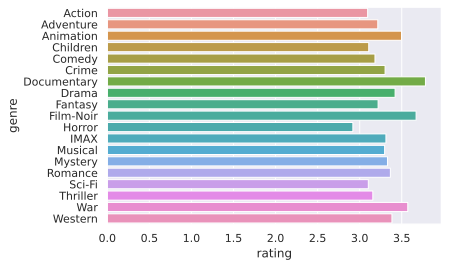

In [33]:
sns.barplot(y='genre', x='rating', data=df_genre_ratings, orient='h')
plt.show()

In [34]:
df_ratings = pd.read_csv('ratings.csv')

In [35]:
from datetime import datetime

df_ratings['timestamp'] = df_ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

df_ratings['rank_latest'] = df_ratings.groupby('userId')['timestamp'].rank(method='first', ascending=False)

In [36]:
df_ratings

,userId,movieId,rating,timestamp,rank_latest
0,1,1,4.0,2000-07-30 18:45:03,86.0
1,1,3,4.0,2000-07-30 18:20:47,196.0
2,1,6,4.0,2000-07-30 18:37:04,141.0
3,1,47,5.0,2000-07-30 19:03:35,18.0
4,1,50,5.0,2000-07-30 18:48:51,66.0
...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,314.0
100832,610,168248,5.0,2017-05-03 22:21:31,95.0
100833,610,168250,5.0,2017-05-08 19:50:47,23.0
100834,610,168252,5.0,2017-05-03 21:19:12,615.0


### Data split

In [37]:
train_data = df_ratings[df_ratings['rank_latest'] != 1 ]
test_data = df_ratings[df_ratings['rank_latest'] == 1 ]

train_data = train_data[['userId', 'movieId', 'rating']]
test_data = test_data[['userId', 'movieId', 'rating']]

In [38]:
train_data['rating'] = 1

In [39]:
def augment_data_with_negatives(all_data: pd.DataFrame, split_data: pd.DataFrame) -> pd.DataFrame:
  all_movieIds = all_data['movieId'].unique()

  users, items, labels = [], [], []

  user_item_set = set(zip(split_data['userId'], split_data['movieId']))

  num_negatives = 4

  for (u, i) in user_item_set:
      users.append(u)
      items.append(i)
      labels.append(1)
      for _ in range(num_negatives):
          
          negative_item = np.random.choice(all_movieIds) 
          
          while (u, negative_item) in user_item_set:
              negative_item = np.random.choice(all_movieIds)
          users.append(u)
          items.append(negative_item)
          labels.append(0)

  df_new = pd.DataFrame(
    {'user': users,
     'movie': items,
     'label': labels
    })
  
  return df_new


In [40]:
df_train = augment_data_with_negatives(df_ratings, train_data)
df_test = augment_data_with_negatives(df_ratings, test_data)

In [41]:
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=42)

In [42]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Recommender System

### Dataset + Datamodule

In [43]:
class MovieDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame
  ):
    self.data = data

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index: int):
    user = self.data['user']
    movie = self.data['movie']
    label = self.data['label']

    return torch.tensor(user[index]), torch.tensor(movie[index]), torch.tensor(label[index])

In [44]:
class MovieDataModule(pl.LightningDataModule):
    def __init__(self, df_train, df_val, df_test, batch_size=64):
      super().__init__()
      self.batch_size = batch_size
      self.df_train = df_train
      self.df_val = df_val
      self.df_test = df_test

    def setup(self, stage=None):
      self.train_dataset = MovieDataset(self.df_train)
      self.val_dataset = MovieDataset(self.df_val)
      self.test_dataset = MovieDataset(self.df_test)

    def train_dataloader(self):
      return DataLoader(self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=2,
        drop_last = True)


    def val_dataloader(self):
      return DataLoader(self.val_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2,
        drop_last = True)

    def test_dataloader(self):
      return DataLoader(self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2,
        drop_last = True)

### Modelo usando NCF 🧠

In [45]:
class NCF(pl.LightningModule):
  def __init__(self, hparams):
    super().__init__()
    embedding_dim = 16
    num_users = hparams['num_users']
    num_items = hparams['num_movies']
    batch_size = hparams['batch_size']
    learning_rate = hparams['lr']

    self.user_emb = nn.Embedding(num_users+1, embedding_dim=embedding_dim)
    self.item_emb = nn.Embedding(num_items+1, embedding_dim=embedding_dim)
    self.fc1 = nn.Linear(embedding_dim * 2, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 1)

    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.criterion = nn.BCEWithLogitsLoss()
    
    self.accuracy = torchmetrics.Accuracy()
    self.auroc = AUROC(num_classes=1)
    self.f1 = F1Score(num_classes=1)

  def forward(self, user_input, movie_input, label_input = None):
    user_x = self.user_emb(user_input)
    movie_x = self.item_emb(movie_input)
    concat = torch.concat([user_x, movie_x], dim=-1)
    x = F.relu(self.fc1(concat))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    loss = 0
    if label_input != None: 
      # loss = self.criterion(x, label_input.view(-1, 1).float())
      loss = self.criterion(x.squeeze(-1), label_input.float())

    return loss, x

  def training_step(self, batch, batch_idx):
    user_input, movie_input, label_input = batch
    loss, logits = self(user_input, movie_input, label_input)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
  
    return loss

  def validation_step(self, batch, batch_idx):
    user_input, movie_input, label_input = batch
    loss, logits = self(user_input, movie_input, label_input)
    self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)

    return loss

  def test_step(self, batch, batch_idx):
    user_input, movie_input, label_input = batch
    loss, logits = self(user_input, movie_input, label_input)
    self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=BATCH_SIZE)

    self.accuracy(torch.sigmoid(logits.squeeze(-1)), label_input)
    self.log('test_acc', self.accuracy, on_step=True, on_epoch=True)

    self.f1(torch.sigmoid(logits.squeeze(-1)), label_input)
    self.log('test_f1', self.f1, on_step=False, on_epoch=True)

    self.auroc(torch.sigmoid(logits.squeeze(-1)), label_input)
    self.log('test_auroc', self.auroc, on_step=False, on_epoch=True)

    return loss

  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr=self.learning_rate)

El id de la pelicula y el id del usuario son vectorizados utilizando cada uno su embedding correspondiente. Luego, ambos vectores son concatenados y pasan por unas capas fully connected. Se utiliza BCEWithLogitsLoss ya que se va a tratar solamente de predecir si un usuario daria click o no a una pelicula.

### Entrenamiento 🏃

In [46]:
BATCH_SIZE = 512
N_EPOCHS = 50
LR = 3e-4

In [47]:
dm = MovieDataModule(df_train, df_val, df_test, BATCH_SIZE)

In [48]:
num_movies = df_ratings['movieId'].unique().max()
num_users = df_ratings['userId'].unique().max()

In [49]:
print(num_movies)
print(num_users)

193609
610


In [50]:
hparams = {'num_users': num_users, 'num_movies': num_movies, 'batch_size': BATCH_SIZE, 'lr': LR}
model = NCF(hparams)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [51]:
checkpoint_callback = ModelCheckpoint(
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [52]:
trainer = pl.Trainer(
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=10,
    gpus=1,
    auto_lr_find=True,
    # accumulate_grad_batches=25
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, dm)

### Probamos el modelo

In [ ]:
model = NCF.load_from_checkpoint(
  '/drive/MyDrive/ml-latest-small/lightning_logs/version_23/checkpoints/epoch=9-step=8309.ckpt',
  hparams=hparams
)

model.eval()
model.freeze()

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
trainer.test(model = model, datamodule=dm)

In [ ]:
print(hparams)

{'num_users': 610, 'num_movies': 193609, 'batch_size': 512, 'lr': 0.0003}
